###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 2: Book Rating Prediction

**Student IDs:**     1264462 & 1269549

# README

* To run the complete code in Jupyter Notebook, simply click Kernel > Restart & Run All.
    * Note that it might take a while to generate the output - the slowest model takes about < 7 minutes.
    * Alternatively, select the relevant cell, and click 'Run'.
* Code lines commented out with `##` are for printing out information that may be of interest. You may uncomment it to see the output.
* The dataset files (both the original and preprocessed) are assumed to exist in a folder named '**Datasets**', which resides in the same directory as this notebook.
* There are two helper notebooks in the same directory, namely "TextPreprocessing.ipynb" and "HelperFunctions.ipynb". Here we make use of the IPython built-in magic command (`%run`) to run these files. You do not need to open and run them separately.
* This code makes use of a library "mlxtend". To install it, run in the terminal: `pip install mlxtend`.
    * More details about this library can be found here: https://rasbt.github.io/mlxtend/.
* Each model may use a different version of the preprocessed dataset. Running this code generates the "train_df_ohe.csv" and "train_df_oe.csv" file. 
    * We have generated the other versions beforehand ("train_df_ohe_300", "train_df_oe_300"), which only requires a small change in a function parameter.
    * All required, preprocessed datasets lie in the 'Datasets' folder.
* This code also generates a file of the format "[model]_pred.csv", which contains the final predictions made by the selected model on the test set.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, SelectKBest, SelectFromModel

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%run TextPreprocessing.ipynb
%run HelperFunctions.ipynb

In [4]:
DATASET_DIR = "./Datasets/"
CLASS_LABEL = "rating_label"

In [5]:
# Load datasets
train_df = pd.read_csv(DATASET_DIR + "book_rating_train.csv", index_col = False, delimiter = ',', header=0)
test_df = pd.read_csv(DATASET_DIR + "book_rating_test.csv", index_col = False, delimiter = ',', header=0)
entire_df = pd.concat([train_df, test_df])

# 1. Data Preprocessing

Note: Here we show the individual preprocessing steps for the training set for clarity. At the end we pull everything together to preprocess the test set.

## Preprocess String features: Authors and Publisher

In [6]:
CATEGORICAL_FEATURES = ['Authors', 'Publisher']
MISSING_CAT_VAL = ''

In [7]:
train_df = train_df.drop('Language', axis=1)  # this feature has too many missing values

for df in [train_df, entire_df]:
    for feature in CATEGORICAL_FEATURES:
        df[feature] = df[feature].fillna(MISSING_CAT_VAL)  # impute missing values
        df[feature] = df[feature].apply(lambda x: preprocess(x, stop_words_removal=False, lemmatize=False, min_word_len=0))

### Version 1: One-Hot Encoding
Some models will use different encodings of the categorical features.

In [8]:
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=3, sparse=False)
OHE.fit(entire_df[CATEGORICAL_FEATURES])

OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=3,
              sparse=False, sparse_output=False)

In [9]:
def ohe_transform(df, has_labels=False):
    """
    Transforms the dataset by one-hot-encoding, on the categorical features only.
    `has_label` indicates whether the DataFrame contains the class labels.
        If True, these are moved to the last column.
    Returns the transformed DataFrame.
    """
    transformed_mat = OHE.transform(df[CATEGORICAL_FEATURES])
    transformed_cat_df = pd.DataFrame(transformed_mat).set_axis(OHE.get_feature_names_out(), axis=1, inplace=False)
    transformed_df = pd.concat([df.reset_index(drop=True), transformed_cat_df], axis=1)
    transformed_df = transformed_df.drop(CATEGORICAL_FEATURES, axis=1)  # drop the original attributes
    
    if has_labels:
        # move rating_label to the last column
        labels = transformed_df[CLASS_LABEL]
        transformed_df = pd.concat([transformed_df.drop([CLASS_LABEL], axis=1), labels], axis=1)
    
    return transformed_df

In [10]:
ALPHA = 0.05

# Select one-hot-encoded features using chi2
x2 = SelectKBest(chi2, k='all')
x2.fit(ohe_transform(train_df)[OHE.get_feature_names_out()], train_df[CLASS_LABEL])
pvals = pd.DataFrame(x2.pvalues_, index=x2.feature_names_in_, columns=['p-value'])
## print(pvals)

INSIG_OHE_FEATURES = pvals[pvals['p-value'] >= ALPHA].index.tolist()  # insignificant encoded features
sig_ohe_features = pvals[pvals['p-value'] < ALPHA].index.tolist()
print(len(sig_ohe_features), "features are significant.")
## sig_ohe_features

497 features are significant.


### Version 2: Ordinal Encoding

In [11]:
from sklearn.preprocessing import OrdinalEncoder

ORD_ENCODER = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
ORD_ENCODER.fit(entire_df[CATEGORICAL_FEATURES])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [12]:
def ord_enc_transform(df):
    """
    Transforms the dataset by one-hot-encoding, on the categorical features only.
    Returns the transformed DataFrame.
    """
    df = df.copy()
    df[CATEGORICAL_FEATURES] = ORD_ENCODER.transform(df[CATEGORICAL_FEATURES])
    for i in range(len(CATEGORICAL_FEATURES)):  
        # some models (e.g. CategoricalNB), cannot handle negative values, so we replace -1 with the next unused int to denote unseen values
        df[CATEGORICAL_FEATURES[i]] = df[CATEGORICAL_FEATURES[i]].replace(-1, ORD_ENCODER.categories_[i].size)
    
    return df

## Discretize 'Numerical' features

In [13]:
from sklearn.preprocessing import KBinsDiscretizer

def discretize(df, feature, discretizer=None, strategy='kmeans', n_bins=5):
    """
    Discretizes the feature in the given DataFrame.
    - discretizer: the discretizer; 
      If None, creates a KBinsDiscretizer for ordinal data, with the specified strategy and number of bins.
    - strategy: the discretization strategy (one of ['kmeans', 'quantile', 'uniform']).
    - n_bins: the number of bins.
    Returns the transformed dataset and discretizer used.
    """
    
    if discretizer is None:
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        discretizer.fit(df[[feature]])
        
    transformed_df = df.copy()
    transformed_df[feature] = discretizer.transform(df[[feature]])
    
    return transformed_df, discretizer

In [14]:
# PublishYear
train_df, DISCRETIZER_PY = discretize(train_df, 'PublishYear', strategy='uniform', n_bins=15)

# PublishMonth
train_df, DISCRETIZER_PM = discretize(train_df, 'PublishMonth', strategy='quantile', n_bins=6)

# PublishDay
train_df, DISCRETIZER_PD = discretize(train_df, 'PublishDay', strategy='quantile', n_bins=11)

# pagesNumber
train_df, DISCRETIZER_PN = discretize(train_df, 'pagesNumber', strategy='kmeans', n_bins=7)

## Text Pre-processing

In [15]:
TEXT_FEATURES = ['Name', 'Description']

In [16]:
# set max_features=300 to generate the dataset version for the Logistic Regression classifier
train_df_name, VECTORIZER_NAME = preprocess_text_feature(train_df, 'Name', ngram=2, delimiter='_')  # distinguish from Description features
train_df_desc, VECTORIZER_DESC = preprocess_text_feature(train_df, 'Description', ngram=2)

In [17]:
# Bind them together
train_df = pd.concat([train_df.reset_index(drop=True), train_df_name, train_df_desc], axis=1)
train_df = train_df.drop(TEXT_FEATURES, axis=1)  # drop the original columns

In [18]:
# Finally, move rating_label to the last column
labels = train_df[CLASS_LABEL].astype('category')
train_df = pd.concat([train_df.drop([CLASS_LABEL], axis=1), labels], axis=1) 

## Altogether

In [19]:
def preprocess_test_df(df):
    """
    Preprocesses the test dataset and returns the preprocessed version as a DataFrame.
    """
    df = df.copy()
    
    # preprocess string features
    for feature in CATEGORICAL_FEATURES:
        df[feature] = df[feature].fillna(MISSING_CAT_VAL)  # imputation
        df[feature] = df[feature].apply(lambda x: preprocess(str(x), stop_words_removal=False, lemmatize=False, min_word_len=0))
    
    # preprocess numerical features
    df = discretize(df, 'PublishDay', discretizer=DISCRETIZER_PD)[0]
    df = discretize(df, 'PublishMonth', discretizer=DISCRETIZER_PM)[0]
    df = discretize(df, 'PublishYear', discretizer=DISCRETIZER_PY)[0]
    df = discretize(df, 'pagesNumber', discretizer=DISCRETIZER_PN)[0]
    
    # preprocess text features
    df_name = preprocess_text_feature(df, 'Name', vectorizer=VECTORIZER_NAME, delimiter='_')[0]
    df_desc = preprocess_text_feature(df, 'Description', vectorizer=VECTORIZER_DESC)[0]
    
    # discard the obsolete original features and unwanted features
    df = pd.concat([df.reset_index(drop=True), df_name, df_desc], axis=1)
    df = df.drop(['Name', 'Description', 'Language'], axis=1)
        
    return df

In [20]:
# For simplicity, we save the preprocessed datasets
train_df.to_csv(DATASET_DIR + "train_df.csv", index=False)

# Encoded versions
train_df_ohe = ohe_transform(train_df, has_labels=True).drop(INSIG_OHE_FEATURES, axis=1)  # drop the 'insignificant' OHE features
train_df_oe = ord_enc_transform(train_df)
train_df_ohe.to_csv(DATASET_DIR + "train_df_ohe.csv", index=False)
train_df_oe.to_csv(DATASET_DIR + "train_df_oe.csv", index=False)

In [21]:
# Apply to the test set
test_df = preprocess_test_df(test_df)

test_df_ohe = ohe_transform(test_df)
test_df_oe = ord_enc_transform(test_df)
test_df_ohe.to_csv(DATASET_DIR + "test_df_ohe.csv", index=False)
test_df_oe.to_csv(DATASET_DIR + "test_df_oe.csv", index=False)

# 2. Building the models

Training sets for each model:
- `logr`: train_df_ohe_300.csv, the one-hot-encoded dataset with 300 'Name' and 'Description' features, respectively.
        This is generated by setting `max_features=300` in the `preprocess_text_feature()` function.
- `rf`, `cvsnb`, baselines: train_df_ohe.csv, the one-hot-encoded dataset with 50 'Name' and 'Description' features, respectively.
- `sclf`: train_df_oe.csv, the ordinal-encoded dataset with 50 'Name' and 'Description' features, respectively.

In [22]:
## train_df_ohe = pd.read_csv(DATASET_DIR + "train_df_ohe.csv", keep_default_na=False)  # Alternative
X_train = train_df_ohe.iloc[:,:-1]
y_train = train_df_ohe.iloc[:,-1]

## 1) Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
RF_FEATURES = chi2_select_features(X_train, y_train)
RF_FEATURES.remove('PublishDay')

rf = RandomForestClassifier(random_state=30027, 
                            max_samples=0.3, max_features='log2', 
                            criterion='entropy', n_estimators=100, 
                            oob_score=True)

RandomForestClassifier prediction took 25.449363946914673 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.571429    0.143101      0.228883       0.723305    0.961135   
1       0.576000    0.122658      0.202247       0.721531    0.965453   
2       0.565574    0.117747      0.194915       0.720202    0.965453   
3       0.482014    0.114334      0.184828       0.719331    0.954966   
4       0.559701    0.127986      0.208333       0.723739    0.964837   
5       0.633028    0.117747      0.198561       0.723394    0.972856   
6       0.557971    0.131399      0.212707       0.722763    0.961752   
7       0.614035    0.119454      0.200000       0.722400    0.972856   
8       0.628099    0.129472      0.214689       0.723963    0.969753   
9       0.626984    0.134583      0.221599       0.724838    0.969136   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.825430       0.500000    0.030303      0.057143  0

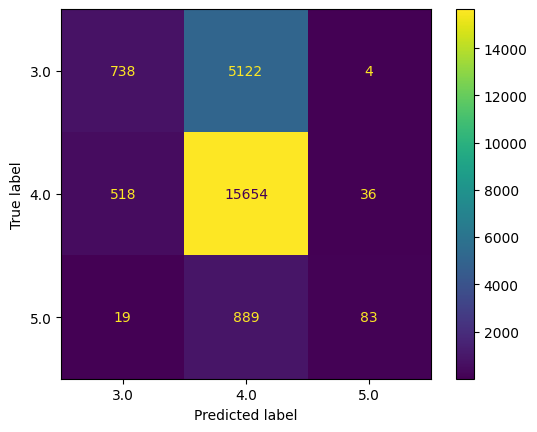

,mean,std
3.0_precision,0.581484,0.046267
3.0_recall,0.125848,0.009051
3.0_f1-score,0.206676,0.013186
4.0_precision,0.722547,0.001729
4.0_recall,0.965820,0.005608
4.0_f1-score,0.826653,0.002845
5.0_precision,0.672662,0.122790
5.0_recall,0.083778,0.025282
5.0_f1-score,0.148158,0.042207
accuracy,0.714348,0.004422


In [25]:
rf.fit(X_train[RF_FEATURES], y_train)
y_pred_rf, rf_report = cross_val_report(rf, X_train[RF_FEATURES], y_train)
rf_report

In [26]:
rf.oob_score_

0.7150847678099119

## 2) StackingClassifier

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingCVClassifier

In [28]:
# Gaussian NB
gnb = GaussianNB()
# Linear SVM
linearSVM = svm.LinearSVC(random_state=30027, C=1)
# Logistic Regression
logr = LogisticRegression(solver='sag', max_iter=100)
# Decision tree
dt = DecisionTreeClassifier(max_depth = 400, random_state = 30027)
# 3NN
knn = KNeighborsClassifier(n_neighbors=3)

# Stack
sclf = StackingCVClassifier(classifiers=[gnb, linearSVM, logr, dt, knn], 
                            meta_classifier=LogisticRegression(),
                            cv=2,
                            random_state=30027)

sclf.fit(X_train, y_train)

StackingCVClassifier(classifiers=[GaussianNB(),
                                  LinearSVC(C=1, random_state=30027),
                                  LogisticRegression(solver='sag'),
                                  DecisionTreeClassifier(max_depth=400,
                                                         random_state=30027),
                                  KNeighborsClassifier(n_neighbors=3)],
                     meta_classifier=LogisticRegression(), random_state=30027)

In [ ]:
# This is slow - be patient!
y_pred_sclf, sclf_report = cross_val_report(sclf, X_train, y_train)
sclf_report

StackingCVClassifier prediction took 401.21338295936584 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.733728    0.211244      0.328042       0.738296    0.972856   
1       0.732394    0.177172      0.285322       0.731854    0.976558   
2       0.701754    0.204778      0.317041       0.736842    0.967304   
3       0.730263    0.189420      0.300813       0.734201    0.974707   
4       0.751479    0.216724      0.336424       0.739456    0.973473   
5       0.687075    0.172355      0.275580       0.732960    0.968538   
6       0.744526    0.174061      0.282158       0.731426    0.977791   
7       0.733766    0.192833      0.305405       0.735814    0.975941   
8       0.783217    0.190801      0.306849       0.734628    0.980864   
9       0.726027    0.180579      0.289222       0.733519    0.975309   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.839500       0.000000    0.000000      0.000000  0.7

## 3) Logistic Regression

In [ ]:
train_df_logr = pd.read_csv(DATASET_DIR + "train_df_ohe_300.csv", keep_default_na=False)
X_train_logr = train_df_logr.iloc[:,:-1]

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logr = LogisticRegression(solver='sag', max_iter=500)  # uses Stochastic Average Gradient descent solver
logr.fit(X_train_logr, y_train)

In [ ]:
selector = SelectFromModel(logr, prefit=True).fit(X_train_logr, y_train)
LR_FEATURES = [X_train_logr.columns[i] for i in selector.get_support(indices=True)]

In [ ]:
logr.fit(X_train_logr[LR_FEATURES], y_train)
y_pred_logr, logr_report = cross_val_report(logr, X_train_logr[LR_FEATURES], y_train)
logr_report

## 4) Stacking Naive Bayes

In [ ]:
train_df_oe = pd.read_csv(DATASET_DIR + "train_df_oe.csv", keep_default_na=False)
y_train_oe = train_df_oe.iloc[:,-1]
X_train_oe = train_df_oe.iloc[:,:-1]

In [ ]:
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB

In [ ]:
GAUS_FEATURES = ['pagesNumber', 'PublishYear']
CAT_FEATURES = ['Authors']
MN_FEATURES = chi2_select_features(X_train_oe[X_train_oe.columns[6:]], y_train_oe)  # only filtering the text features
N_AUTHORS_VALS = len(ORD_ENCODER.categories_[0])  # number of unique Authors categories

X_train_oe = X_train_oe[GAUS_FEATURES + CAT_FEATURES + MN_FEATURES]
## X_train_oe

In [ ]:
gnb = make_pipeline(ColumnSelector(GAUS_FEATURES),
                      GaussianNB())
cnb = make_pipeline(ColumnSelector(CAT_FEATURES),
                      CategoricalNB(alpha=0.11, min_categories=N_AUTHORS_VALS))
mnb = make_pipeline(ColumnSelector(MN_FEATURES),
                      MultinomialNB(alpha=0.26))

cvsnb = StackingCVClassifier(classifiers=[gnb, cnb, mnb], 
                            meta_classifier=CategoricalNB(),
                            random_state=30027)

cvsnb.fit(X_train_oe, y_train_oe)

In [ ]:
y_pred_cvsnb, cvsnb_report = cross_val_report(cvsnb, X_train_oe, y_train_oe)
cvsnb_report

## 5) Baselines

### 0R

In [ ]:
from sklearn.dummy import DummyClassifier

zero_r = DummyClassifier(strategy='most_frequent')
y_pred_zero_r, zero_r_report = cross_val_report(zero_r, X_train, y_train)
zero_r_report

### 1R

In [ ]:
from sklearn.tree import DecisionTreeClassifier

one_r = DecisionTreeClassifier(max_depth=1)
y_pred_one_r, one_r_report = cross_val_report(one_r, X_train, y_train)
one_r_report

# 3. Final predictions on the test set

In [ ]:
# Stacking Clf
X_test_sclf = pd.read_csv(DATASET_DIR + "test_df_ohe.csv", keep_default_na=False).drop(INSIG_OHE_FEATURES, axis=1)
get_pred_df(sclf.predict(X_test_sclf)).to_csv("sclf_pred.csv", index=False)
pd.read_csv("sclf_pred.csv")  # how the results look

In [ ]:
# Random Forest
X_test_rf = pd.read_csv(DATASET_DIR + "test_df_ohe.csv", keep_default_na=False)
get_pred_df(rf.predict(X_test_rf[RF_FEATURES])).to_csv("rf_pred.csv", index=False)

In [ ]:
# Logistic Regression
X_test_logr = pd.read_csv(DATASET_DIR + "test_df_ohe_300.csv", keep_default_na=False)
get_pred_df(logr.predict(X_test_logr[LR_FEATURES])).to_csv("logr_pred.csv", index=False)

In [ ]:
# Stacking NB
X_test_cvsnb = pd.read_csv(DATASET_DIR + "test_df_oe.csv", keep_default_na=False)
get_pred_df(cvsnb.predict(X_test_cvsnb)).to_csv("cvsnb_pred.csv", index=False)